In [1]:
import pandas as pd
import os
import numpy as np
import rasterio

import torch
import torchvision.transforms as transforms
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision import transforms

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA, KernelPCA


import matplotlib.pyplot as plt

from scipy.stats import pearsonr

#from torchgeo.models.resnet import ResNet50_Weights
#from torchgeo.models import resnet50

In [22]:
SENTINEL2_RGB_SECO = 'https://huggingface.co/torchgeo/resnet50_sentinel2_rgb_seco/resolve/main/resnet50_sentinel2_rgb_seco-018bf397.pth'

#weights = ResNet50_Weights.SENTINEL2_RGB_SECO

weights = torch.hub.load_state_dict_from_url(SENTINEL2_RGB_SECO)

In [23]:
model = resnet50(weights=weights)
model = torch.nn.Sequential(*(list(model.children())[:-5]))

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = model  # Using truncated ResNet
        # Freeze the layers of truncated ResNet
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # fine-tunable layer

        self.finetune_layer = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(),
        )
        '''
        self.finetune_layer = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=1),
            nn.ReLU()
        )

        '''
        self.upsample = nn.Upsample(size=(100, 100), mode='bilinear', align_corners=True)
        

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: 200x200
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: 400x400
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),  # Output: 800x800
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # Output: 800x800
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),  # Output: 800x800
            nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)  # Output: 256x256
        )

        
    def forward(self, x):
        x = self.encoder(x)
        x = self.finetune_layer(x)  # Pass through the fine-tunable layer
        x = self.upsample(x) 
        x = self.decoder(x)
        return x


autoencoder = Autoencoder()
autoencoder.to('cuda')
criterion = nn.MSELoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, autoencoder.parameters()), lr=0.001, momentum=0.9)

In [4]:
# Load state dictionary
#autoencoder.load_state_dict(torch.load('model/autoencoder_tif_3stations_finetuned_08_10_23.pth'))
autoencoder = torch.load('model/autoencoder_tif_3stations_finetuned_08_10_23.pth')

In [24]:
class IntermediateFeatureExtractor(nn.Module):
    def __init__(self, autoencoder):
        super(IntermediateFeatureExtractor, self).__init__()
        self.encoder = autoencoder.encoder
        self.finetune_layer = autoencoder.finetune_layer
        self.upsample = autoencoder.upsample

    def forward(self, x):
        x = self.encoder(x)
        x = self.finetune_layer(x)
        x = self.upsample(x)
        return x

 

In [25]:
autoencoder.cuda()

def extract_features(image_path):
    img = Image.open(image_path)
    if img.mode == 'RGBA':
        img = img.convert("RGB")

    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(img).cuda()
    input_batch = input_tensor.unsqueeze(0)

    intermediate_extractor = IntermediateFeatureExtractor(autoencoder)
    features = intermediate_extractor(input_batch)
    
    #single_channel_features = features[:, i, :, :]
    #mean_value = torch.mean(single_channel_features).item()
    return features



#features = extract_features("Satellite_Data/Stasiun Klimatologi Jawa Barat/Stasiun Klimatologi Jawa Barat_2017-06-14.png", autoencoder)


In [26]:
image_path = "Satellite_Data/Stasiun Geofisika Nganjuk/Stasiun Geofisika Nganjuk_2022-08-21.png"   

img = Image.open(image_path)
if img.mode == 'RGBA':
    img = img.convert("RGB")

In [27]:
features = extract_features(image_path)

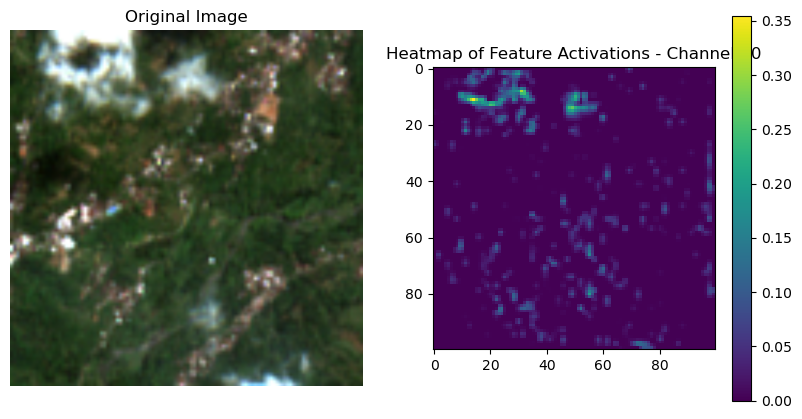

In [28]:
channel_number = 10
feature_maps = features[0].detach().cpu().numpy()  # Select the feature maps of the first image in the batch
single_channel_map = feature_maps[channel_number]


plt.figure(figsize=(10, 5))

# original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# heatmap
plt.subplot(1, 2, 2)
#plt.figure(figsize=(10, 10))
plt.imshow(single_channel_map, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(f'Heatmap of Feature Activations - Channel {channel_number}')
plt.show()


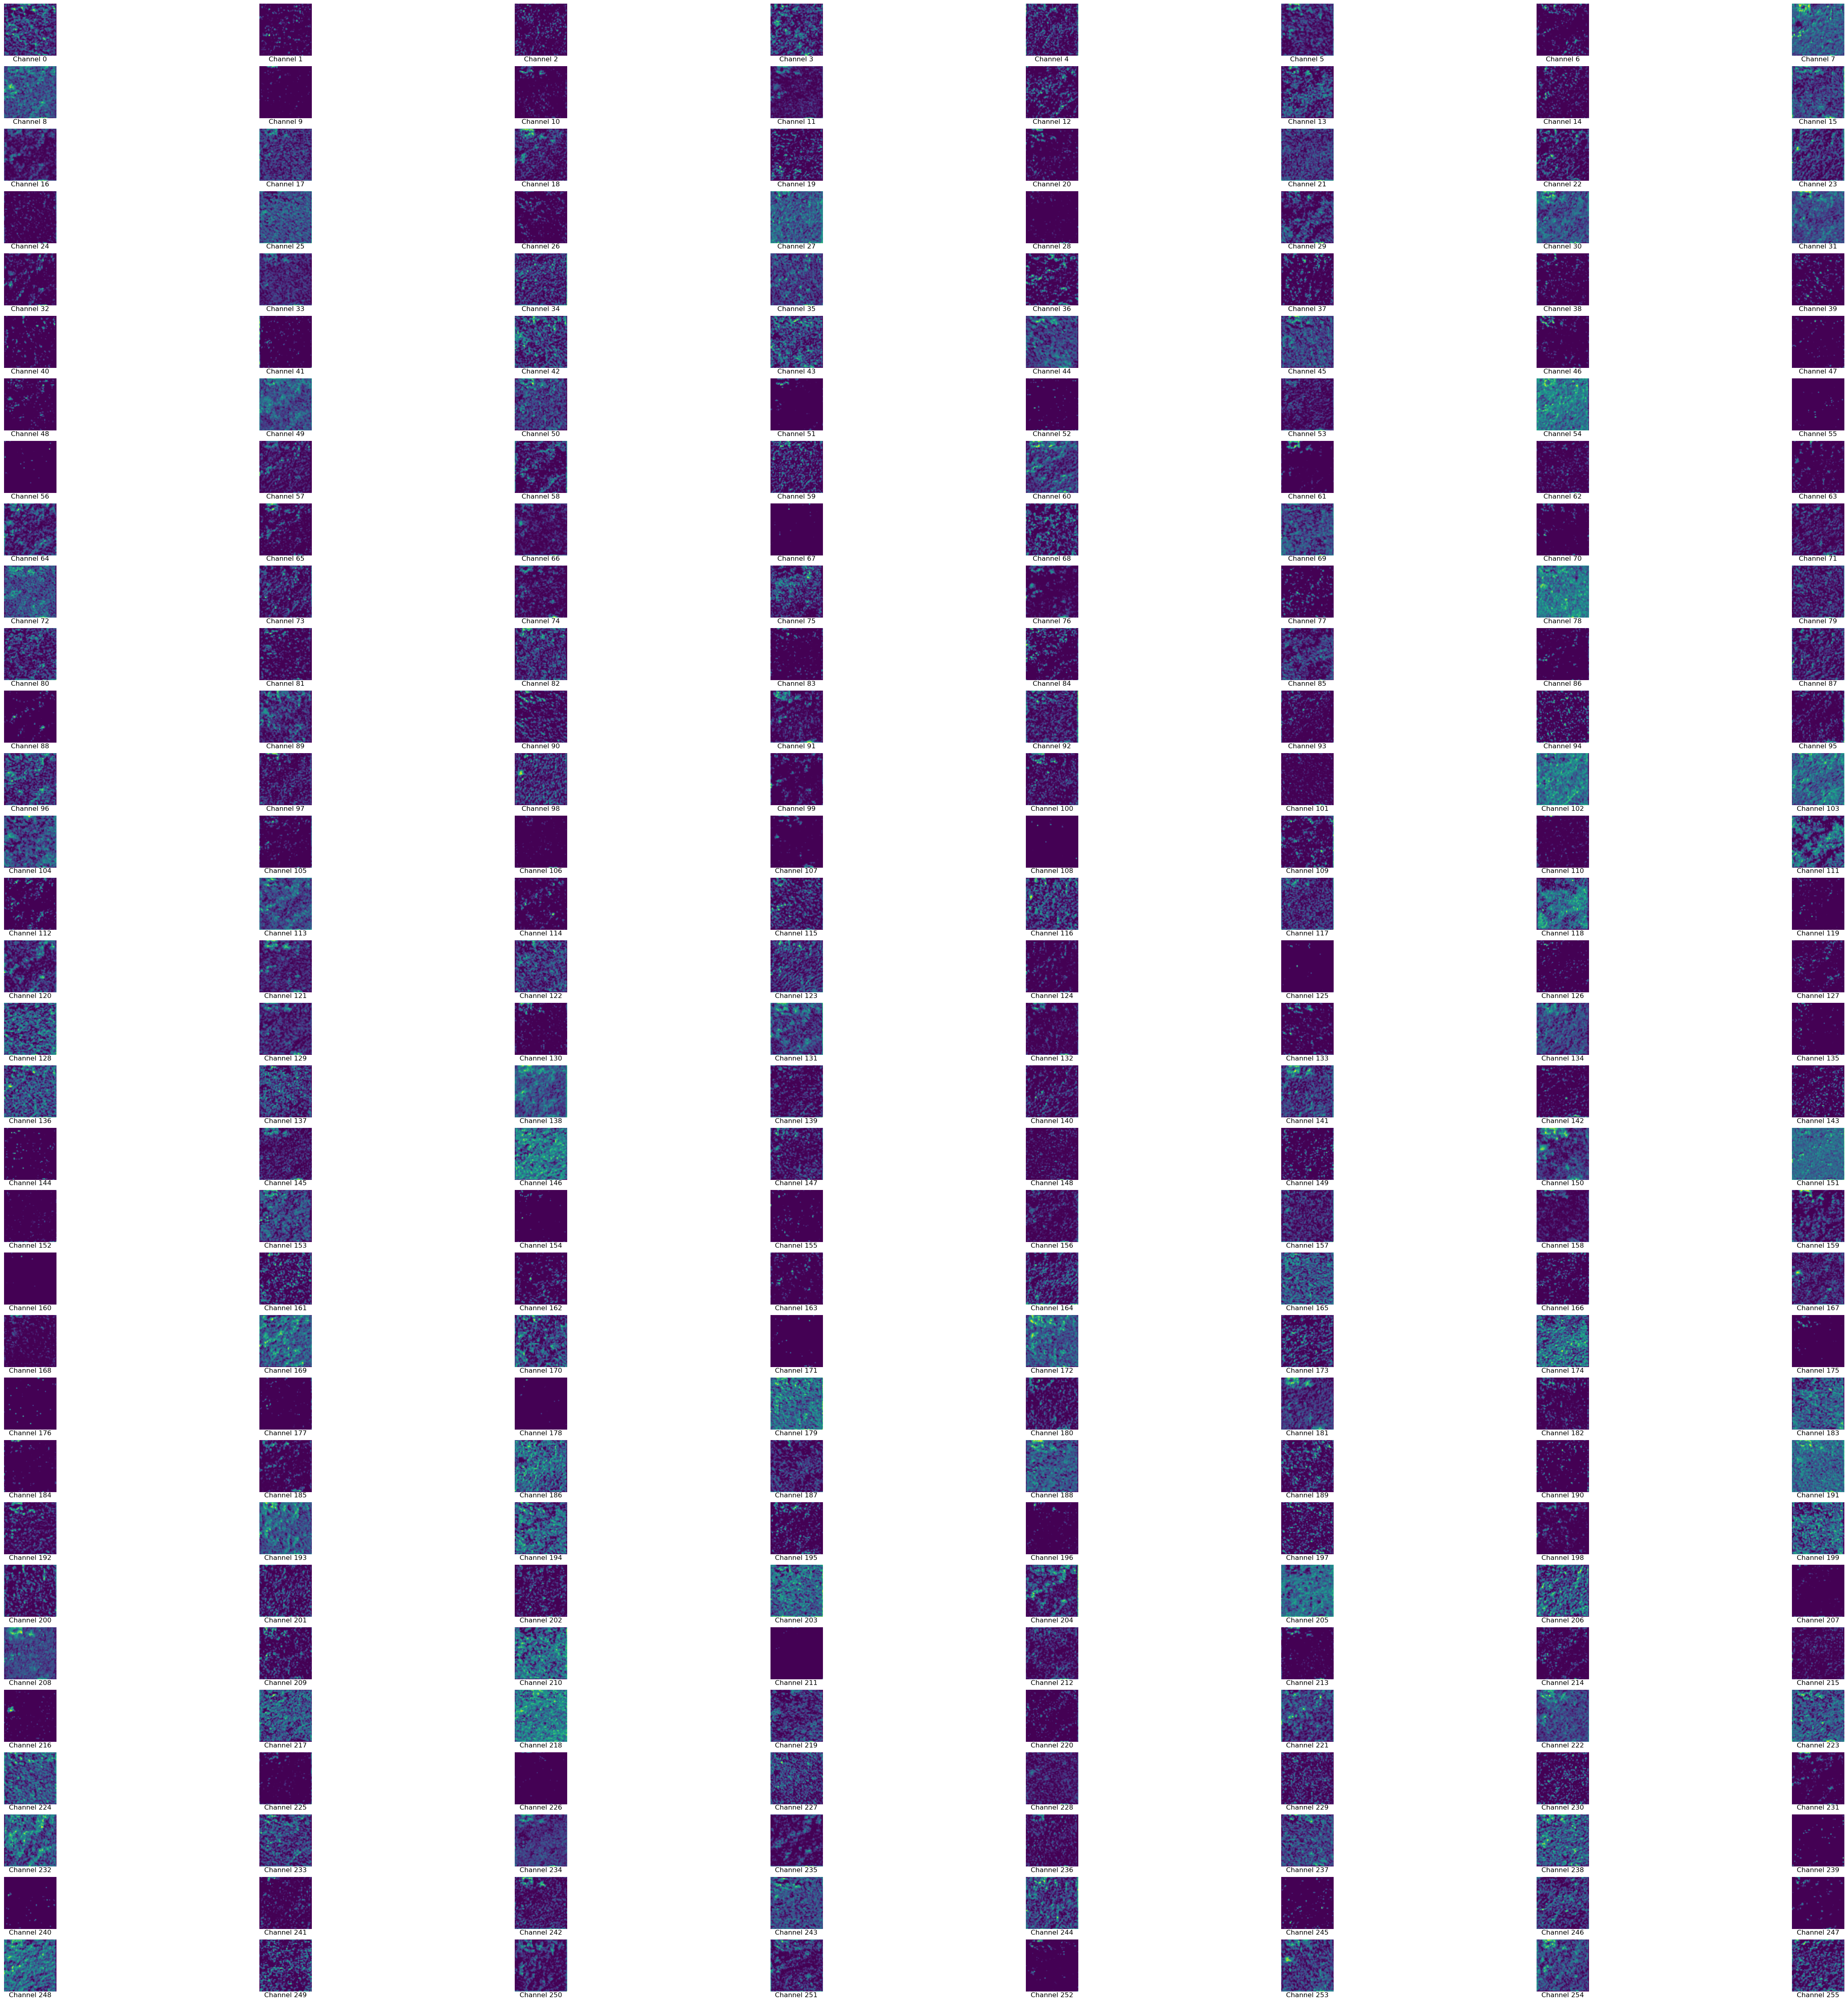

In [29]:
feature_maps = features[0].detach().cpu().numpy()

num_channels = feature_maps.shape[0]
num_columns = 8  # or any other number that you prefer
num_rows = int(np.ceil(num_channels / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, figsize=(64, 64))
for i, ax in enumerate(axes.flat):
    if i < num_channels:
        ax.imshow(feature_maps[i], cmap='viridis')
        ax.axis('off')
        ax.text(0.5, -0.1, f'Channel {i}', fontsize=12, ha='center', transform=ax.transAxes)  # Add channel number
    else:
        ax.remove()
        
#plt.savefig("feature_extraction_resnet.png", format="png")
plt.show()


In [ ]:
tabular_data = pd.read_csv('combined_dataset/nganjuk_combined_tif.csv')
tabular_data ['date'] = pd.to_datetime(tabular_data ['date']).dt.strftime('%Y-%m-%d')

In [ ]:
from datetime import datetime
image_folder = 'Satellite_Data/Stasiun Geofisika Nganjuk'
image_files = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.png')]
image_dates = [os.path.splitext(os.path.basename(fname).split('_')[-1])[0] for fname in image_files]
image_path_dict = dict(zip(image_dates, image_files))
tabular_data['image_path'] = tabular_data['date'].apply(lambda date: image_path_dict.get(date))


In [ ]:
tabular_data

In [ ]:
#tabular_data.to_csv('combined_dataset/jabar_combined_ndvi_tif.csv', index=False)

In [ ]:
column_names = [f'image_features_{i}' for i in range(256)]
new_columns = pd.DataFrame(index=tabular_data.index, columns=column_names)

# IMG feature columns
for i in range(256):
    new_columns[f'image_features_{i}'] = tabular_data['image_path'].apply(lambda path: extract_features(path, i))

tabular_data = pd.concat([tabular_data, new_columns], axis=1)


In [ ]:
#tabular_data.rename(columns={'image_features': 'image_features_0'}, inplace=True)

In [ ]:
#tabular_data.to_csv('combined_dataset/nganjuk_combined_all_features_tif.csv', index=False)

## Input Data

In [30]:
tabular_data = pd.read_csv('combined_dataset/nganjuk_combined_all_features_tif.csv')
tabular_data ['date'] = pd.to_datetime(tabular_data ['date']).dt.strftime('%Y-%m-%d')

In [31]:
tabular_data

date  mean_ndvi    Tn    Tx  Tavg  RH_avg   RR    ss  ff_x  ddd_x  \
0    2022-06-22   0.729961  17.8  28.6  23.9    74.0  0.0   8.5   2.0   80.0   
1    2019-04-19   0.706241  21.4  29.4  24.7    84.0  0.2   7.6   2.0   90.0   
2    2018-10-26   0.397867  20.0  32.6  26.8    60.0  0.0   9.0   1.0  180.0   
3    2020-04-13   0.553098  21.0  27.8  24.7    82.0  0.5   5.8   2.0  360.0   
4    2018-08-27   1.821680  19.0  29.4  23.8    75.0  0.0   9.4   3.0  360.0   
..          ...        ...   ...   ...   ...     ...  ...   ...   ...    ...   
203  2018-05-04   0.726980  20.0  30.6  25.1    79.0  0.0   9.5   2.0  360.0   
204  2020-05-08   0.615215  22.0  30.0  26.3    81.0  0.0   9.6   2.0   90.0   
205  2018-05-09   0.682726  20.0  29.0  24.2    87.0  0.0   9.5   2.0   90.0   
206  2020-06-12   0.724591  19.4  28.5  23.6    73.0  0.0   6.7   1.0  360.0   
207  2022-07-27   0.702602  19.8  29.0  24.3    76.0  0.0  10.3   3.0   10.0   

     ...  image_features_246 image_features_247 image_features_248  \
0    ...            0.152080           1.247398           0.000007   
1    ...            0.118991           1.113301           0.000072   
2    ...            0.145310           0.491924           0.000000   
3    ...            0.192673           0.851379           0.000086   
4    ...            0.390170           0.107868           0.000000   
..   ...                 ...                ...                ...   
203  ...            0.138865           1.220917           0.000000   
204  ...            0.102363           0.885616           0.000126   
205  ...            0.108721           1.062379           0.000022   
206  ...            0.132144           1.184462           0.000000   
207  ...            0.143369           1.180139           0.000023   

     image_features_249  image_features_250  image_features_251  \
0              0.013498            0.831839            0.017013   
1              0.020319            0.758461            0.017514   
2              0.192415            0.527710            0.043016   
3              0.155361            0.770143            0.044387   
4              0.750912            1.348627            0.046545   
..                  ...                 ...                 ...   
203            0.008501            0.795838            0.008668   
204            0.048594            0.593638            0.035632   
205            0.004062            0.669793            0.017434   
206            0.006897            0.765400            0.011851   
207            0.005505            0.730952            0.014986   

     image_features_252  image_features_253 image_features_254  \
0              0.114785            0.002168           1.824956   
1              0.152853            0.003394           1.531781   
2              0.328983            0.009383           0.591902   
3              0.315774            0.008437           1.224527   
4              0.936814            0.003340           0.617724   
..                  ...                 ...                ...   
203            0.119372            0.000460           1.647910   
204            0.142497            0.007144           1.199737   
205            0.081038            0.002699           1.477321   
206            0.102990            0.000447           1.661221   
207            0.069494            0.001444           1.633176   

     image_features_255  
0              1.955175  
1              1.670483  
2              0.762244  
3              1.272393  
4              0.744456  
..                  ...  
203            1.825793  
204            1.315583  
205            1.652766  
206            1.813651  
207            1.821154  

[208 rows x 275 columns]

## Sensor data

In [32]:
num_sensor = ['date','Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']

In [33]:
df_sensor = tabular_data[num_sensor].copy()

In [34]:
# timestamp column and data
timestamp_column = df_sensor[['date']] 
data_to_normalize = df_sensor[['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_normalize)



## PCA & KPCA

In [35]:
pca = PCA()
pca_result = pca.fit_transform(data_scaled)

# Explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

explained_variance_ratio

array([0.37127613, 0.19587784, 0.18358013, 0.09277881, 0.06920853,
       0.03569524, 0.03245   , 0.01913331])

In [36]:
kpca = KernelPCA(n_components=8, kernel='poly', gamma=0.1)
kpca_result = kpca.fit_transform(data_scaled)


kpca_result.shape

(208, 8)

In [37]:
lambdas = kpca.eigenvalues_

# Normalize to get pseudo "explained variance"
explained_variance = lambdas / np.sum(lambdas)
explained_variance

array([0.52478772, 0.11922155, 0.10042239, 0.08450034, 0.06064315,
       0.0515505 , 0.03605733, 0.02281701])

In [38]:
kpca.n_features_in_

8

In [39]:
cumulative_explained_variance = np.cumsum(explained_variance)
cumulative_explained_variance

array([0.52478772, 0.64400927, 0.74443167, 0.82893201, 0.88957515,
       0.94112566, 0.97718299, 1.        ])

In [40]:
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
cumulative_explained_variance

array([0.37127613, 0.56715397, 0.7507341 , 0.84351292, 0.91272145,
       0.94841669, 0.98086669, 1.        ])

In [41]:
# Extracting the components (eigenvectors) to see the composition of each principal component in terms of original features
components = pca.components_

# Creating a DataFrame to map principal components to original features
components_df = pd.DataFrame(components, columns=data_to_normalize.columns, index=[f'PC{i+1}' for i in range(components.shape[0])])

components_df.head()


Tn        Tx      Tavg    RH_avg        RR        ss      ff_x  \
PC1 -0.109068  0.501837  0.373417 -0.484073 -0.226740  0.358599  0.274929   
PC2  0.517993  0.077028  0.298748  0.215435  0.408529 -0.356104  0.397680   
PC3 -0.497495 -0.217189 -0.491668  0.036062  0.107417 -0.011869  0.494300   
PC4 -0.260636  0.123017  0.063833 -0.201315  0.873904  0.228459 -0.206308   
PC5 -0.382595  0.185435  0.129933 -0.317570 -0.039747 -0.827621 -0.105467   

       ff_avg  
PC1  0.326966  
PC2  0.371795  
PC3  0.454178  
PC4 -0.117763  
PC5 -0.061980

In [42]:
n_components = 8
kpca = KernelPCA(n_components=8, kernel='rbf', gamma=0.1)
kernel_principal_components = kpca.fit_transform(data_scaled)

df_kpca = pd.DataFrame(data=kernel_principal_components, columns=[f'KPC{i+1}' for i in range(n_components)])

df_kpca.head()

KPC1      KPC2      KPC3      KPC4      KPC5      KPC6      KPC7  \
0 -0.225408 -0.515726 -0.058146 -0.308214 -0.031379  0.030843  0.138760   
1  0.329157  0.163601 -0.430301  0.060768  0.152821 -0.023038  0.118724   
2 -0.367460  0.537843  0.129747 -0.408027 -0.086562 -0.243335 -0.072535   
3  0.522584  0.011631 -0.237015 -0.008941 -0.061016 -0.013359 -0.099942   
4 -0.246197 -0.408761 -0.235547 -0.104785  0.071664 -0.009759  0.030447   

       KPC8  
0 -0.029187  
1  0.058921  
2 -0.224977  
3  0.115392  
4 -0.035902

In [43]:
n_components = 8
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(data_scaled)

df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

df_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.259482 -2.003861  0.708898  0.445147  0.295361  0.042243  0.026079   
1 -0.722139  0.152844 -1.177715 -0.510952 -0.704227  0.027910  0.238798   
2  2.401261 -0.825552 -2.414119  0.965468  0.809798 -0.184829  0.110805   
3 -1.386668  0.118845 -0.775539 -0.658685 -0.109612  0.031997 -0.521448   
4  0.157545 -1.275416  0.514090  0.150823 -0.410627  0.617032  0.212857   

        PC8  
0 -0.689702  
1  0.063880  
2  0.100502  
3 -0.470187  
4 -0.128317

In [44]:
sensor_normalized = np.column_stack((timestamp_column, data_scaled))
df_sensor = pd.DataFrame(sensor_normalized, columns=['date'] + list(df_sensor.columns)[1:])
df_sensor = pd.concat([df_sensor, df_pca,df_kpca], axis=1)

df_sensor.head()

date        Tn        Tx      Tavg    RH_avg        RR        ss  \
0  2022-06-22 -1.878227 -0.641961 -0.491515 -0.275384 -0.336372  0.527292   
1  2019-04-19  1.105261 -0.103271  0.180532  0.809462 -0.320936  0.165057   
2  2018-10-26 -0.054984  2.051492  1.944654 -1.794168 -0.336372  0.728533   
3  2020-04-13  0.773763 -1.180652  0.180532  0.592493 -0.297781 -0.559413   
4  2018-08-27 -0.883731 -0.103271 -0.575521 -0.166899 -0.336372  0.889526   

       ff_x    ff_avg       PC1  ...       PC7       PC8      KPC1      KPC2  \
0 -0.515688 -0.659153 -0.259482  ...  0.026079 -0.689702 -0.225408 -0.515726   
1 -0.515688 -0.659153 -0.722139  ...  0.238798  0.063880  0.329157  0.163601   
2  -1.27642 -0.659153  2.401261  ...  0.110805  0.100502 -0.367460  0.537843   
3 -0.515688 -0.659153 -1.386668  ... -0.521448 -0.470187  0.522584  0.011631   
4  0.245043 -0.659153  0.157545  ...  0.212857 -0.128317 -0.246197 -0.408761   

       KPC3      KPC4      KPC5      KPC6      KPC7      KPC8  
0 -0.058146 -0.308214 -0.031379  0.030843  0.138760 -0.029187  
1 -0.430301  0.060768  0.152821 -0.023038  0.118724  0.058921  
2  0.129747 -0.408027 -0.086562 -0.243335 -0.072535 -0.224977  
3 -0.237015 -0.008941 -0.061016 -0.013359 -0.099942  0.115392  
4 -0.235547 -0.104785  0.071664 -0.009759  0.030447 -0.035902  

[5 rows x 25 columns]

## Satellite Data

In [45]:
ndvi_date = tabular_data[['date','mean_ndvi']].copy()

In [46]:
column_names = [f'image_features_{i}' for i in range(256)]
features_img = tabular_data[column_names].copy()

In [47]:
df_satellite = pd.concat([ndvi_date, features_img], axis=1)

In [48]:
df_satellite.head()

date  mean_ndvi  image_features_0  image_features_1  \
0  2022-06-22   0.729961          1.234667          0.017514   
1  2019-04-19   0.706241          1.002803          0.026536   
2  2018-10-26   0.397867          0.408247          0.072437   
3  2020-04-13   0.553098          0.734164          0.048622   
4  2018-08-27   1.821680          0.000175          0.013333   

   image_features_2  image_features_3  image_features_4  image_features_5  \
0          0.295844          0.021233          0.010865          0.034761   
1          0.286495          0.037640          0.018028          0.049229   
2          0.072137          0.262173          0.207565          0.034338   
3          0.240578          0.249947          0.190568          0.071869   
4          0.003761          1.032504          0.871338          0.004591   

   image_features_6  image_features_7  ...  image_features_246  \
0          0.073577          0.134089  ...            0.152080   
1          0.112154          0.082364  ...            0.118991   
2          0.133452          0.048246  ...            0.145310   
3          0.150832          0.095808  ...            0.192673   
4          0.008662          0.010152  ...            0.390170   

   image_features_247  image_features_248  image_features_249  \
0            1.247398            0.000007            0.013498   
1            1.113301            0.000072            0.020319   
2            0.491924            0.000000            0.192415   
3            0.851379            0.000086            0.155361   
4            0.107868            0.000000            0.750912   

   image_features_250  image_features_251  image_features_252  \
0            0.831839            0.017013            0.114785   
1            0.758461            0.017514            0.152853   
2            0.527710            0.043016            0.328983   
3            0.770143            0.044387            0.315774   
4            1.348627            0.046545            0.936814   

   image_features_253  image_features_254  image_features_255  
0            0.002168            1.824956            1.955175  
1            0.003394            1.531781            1.670483  
2            0.009383            0.591902            0.762244  
3            0.008437            1.224527            1.272393  
4            0.003340            0.617724            0.744456  

[5 rows x 258 columns]

In [49]:
df_merged = pd.merge(df_sensor, df_satellite, on='date')

## Correlation

In [50]:
# corr test
for sensor_feature in df_sensor.columns:
    for satellite_feature in df_satellite.columns:
        if sensor_feature == 'date' or satellite_feature == 'date':
            continue  
        pearson_corr, _ = pearsonr(df_merged[sensor_feature], df_merged[satellite_feature])
        #print(f"Pearson correlation between {sensor_feature} and {satellite_feature}: {pearson_corr}")


In [51]:
# corr dataframe
corr_df = pd.DataFrame(columns=['Sensor_Feature', 'Satellite_Feature', 'Pearson_Corr'])
corr_list = []

for sensor_feature in df_sensor.columns:
    for satellite_feature in df_satellite.columns:
        if sensor_feature == 'date' or satellite_feature == 'date':
            continue  # Skip date column
        pearson_corr, _ = pearsonr(df_merged[sensor_feature], df_merged[satellite_feature])
        temp_df = pd.DataFrame({
            'Sensor_Feature': [sensor_feature],
            'Satellite_Feature': [satellite_feature],
            'Pearson_Corr': [pearson_corr]
        })
        corr_list.append(temp_df)


corr_df = pd.concat(corr_list, ignore_index=True)


In [52]:
#corr_df.to_csv('combined_dataset/fused/jabar_corr.csv', index=False)

In [53]:
# Sort by the absolute value of Pearson Correlation
corr_df['Abs_Pearson_Corr'] = corr_df['Pearson_Corr'].abs()
sorted_corr_df = corr_df.sort_values(by='Abs_Pearson_Corr', ascending=False)
sorted_corr_df.head(10)

Sensor_Feature   Satellite_Feature  Pearson_Corr  Abs_Pearson_Corr
801          RH_avg   image_features_29     -0.710103          0.710103
2086            PC1   image_features_29      0.704713          0.704713
940          RH_avg  image_features_168      0.692139          0.692139
2290            PC1  image_features_233      0.682488          0.682488
491              Tx  image_features_233      0.668347          0.668347
409              Tx  image_features_151      0.659059          0.659059
2225            PC1  image_features_168     -0.655459          0.655459
4281           KPC1  image_features_168      0.652873          0.652873
666            Tavg  image_features_151      0.649688          0.649688
2208            PC1  image_features_151      0.644522          0.644522

In [54]:
# Filter pairs with strong correlation
strong_corr_df = sorted_corr_df[sorted_corr_df['Abs_Pearson_Corr'] > 0.5]


In [55]:
strong_corr_df

Sensor_Feature   Satellite_Feature  Pearson_Corr  Abs_Pearson_Corr
801          RH_avg   image_features_29     -0.710103          0.710103
2086            PC1   image_features_29      0.704713          0.704713
940          RH_avg  image_features_168      0.692139          0.692139
2290            PC1  image_features_233      0.682488          0.682488
491              Tx  image_features_233      0.668347          0.668347
...             ...                 ...           ...               ...
4279           KPC1  image_features_166      0.501491          0.501491
935          RH_avg  image_features_163      0.501038          0.501038
2240            PC1  image_features_183     -0.500441          0.500441
4213           KPC1  image_features_100      0.500093          0.500093
4271           KPC1  image_features_158      0.500031          0.500031

[117 rows x 4 columns]

## Mutual Information

In [56]:
mi_df = pd.DataFrame(columns=['Sensor_Feature', 'Satellite_Feature', 'Mutual_Info'])
mi_list = []  


#df_merged.dropna(inplace=True)

# Loop through all features to compute Mutual Information
for sensor_feature in df_sensor.columns:
    for satellite_feature in df_satellite.columns:
        if sensor_feature == 'date' or satellite_feature == 'date':
            continue
        
        # Compute Mutual Information
        X = df_merged[[sensor_feature]].values
        y = df_merged[satellite_feature].values
        mi = mutual_info_regression(X, y)[0]

        # Create a DataFrame for the result and append to mi_list
        temp_df = pd.DataFrame({
            'Sensor_Feature': [sensor_feature],
            'Satellite_Feature': [satellite_feature],
            'Mutual_Info': [mi]
        })
        mi_list.append(temp_df)


mi_df = pd.concat(mi_list, ignore_index=True)

sorted_mi_df = mi_df.sort_values(by='Mutual_Info', ascending=False)


In [57]:
sorted_mi_df.head(10)

Sensor_Feature   Satellite_Feature  Mutual_Info
833          RH_avg   image_features_61     0.430256
940          RH_avg  image_features_168     0.395292
2225            PC1  image_features_168     0.393506
2214            PC1  image_features_157     0.391872
2086            PC1   image_features_29     0.386466
2118            PC1   image_features_61     0.385429
2096            PC1   image_features_39     0.361988
666            Tavg  image_features_151     0.360962
2119            PC1   image_features_62     0.353982
4125           KPC1   image_features_12     0.352424

In [58]:
# strong correlation
mi_df = sorted_mi_df[sorted_mi_df['Mutual_Info'] > 0]

In [59]:
#mi_df.to_csv('combined_dataset/fused/jabar_mi.csv', index=False)

In [60]:
sorted_mi_df = mi_df.sort_values(by='Sensor_Feature', ascending=False)

In [61]:
# Merge the mutual information and correlation
select_feature_df = pd.merge(mi_df, corr_df, on=['Sensor_Feature', 'Satellite_Feature'])

# Sort
selected_features = select_feature_df.sort_values(by=['Mutual_Info'], ascending=[False])


selected_features.head(10)


Sensor_Feature   Satellite_Feature  Mutual_Info  Pearson_Corr  \
0         RH_avg   image_features_61     0.430256     -0.621857   
1         RH_avg  image_features_168     0.395292      0.692139   
2            PC1  image_features_168     0.393506     -0.655459   
3            PC1  image_features_157     0.391872     -0.555139   
4            PC1   image_features_29     0.386466      0.704713   
5            PC1   image_features_61     0.385429      0.615930   
6            PC1   image_features_39     0.361988     -0.621471   
7           Tavg  image_features_151     0.360962      0.649688   
8            PC1   image_features_62     0.353982     -0.586885   
9           KPC1   image_features_12     0.352424      0.629838   

   Abs_Pearson_Corr  
0          0.621857  
1          0.692139  
2          0.655459  
3          0.555139  
4          0.704713  
5          0.615930  
6          0.621471  
7          0.649688  
8          0.586885  
9          0.629838

In [62]:
selected_features_3 = select_feature_df.sort_values(by=['Abs_Pearson_Corr'], ascending=[False])

selected_features_3.head(10)

Sensor_Feature   Satellite_Feature  Mutual_Info  Pearson_Corr  \
13          RH_avg   image_features_29     0.336794     -0.710103   
4              PC1   image_features_29     0.386466      0.704713   
1           RH_avg  image_features_168     0.395292      0.692139   
14             PC1  image_features_233     0.335089      0.682488   
190             Tx  image_features_233     0.221498      0.668347   
143             Tx  image_features_151     0.231744      0.659059   
2              PC1  image_features_168     0.393506     -0.655459   
25            KPC1  image_features_168     0.301755      0.652873   
7             Tavg  image_features_151     0.360962      0.649688   
12             PC1  image_features_151     0.341286      0.644522   

     Abs_Pearson_Corr  
13           0.710103  
4            0.704713  
1            0.692139  
14           0.682488  
190          0.668347  
143          0.659059  
2            0.655459  
25           0.652873  
7            0.649688  
12           0.644522

In [221]:
sensor_fs = ['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'KPC1', 'KPC2', 'KPC3', 'KPC4', 'KPC5', 'KPC6', 'KPC7', 'KPC8']

selected_features_subset =[]
for f in sensor_fs:
    _ = selected_features[selected_features['Sensor_Feature'] == f]
    selected_features_subset.append(_.head(1))
    
selected_features = pd.concat(selected_features_subset)
selected_features = selected_features.sort_values(by=['Mutual_Info','Satellite_Feature'], ascending=[False,False])
#Based on Mutial Information
selected_features

Sensor_Feature   Satellite_Feature  Mutual_Info  Pearson_Corr  \
0            RH_avg   image_features_61     0.431797     -0.621857   
1               PC1  image_features_168     0.393506     -0.655459   
6              Tavg  image_features_151     0.364492      0.649688   
9              KPC1   image_features_12     0.352424      0.629838   
24               Tx   image_features_61     0.303357      0.613268   
31             KPC2  image_features_174     0.297018      0.454054   
59             KPC4  image_features_116     0.266127     -0.001061   
82               Tn  image_features_122     0.254132     -0.210974   
142             PC3   image_features_92     0.233322     -0.124573   
237            KPC3   image_features_39     0.209434      0.043589   
276             PC2   image_features_91     0.201922     -0.226605   
315            KPC5  image_features_111     0.194388      0.158272   
324              ss    image_features_9     0.193253     -0.239083   
365            KPC7  image_features_250     0.183981     -0.044265   
405             PC4   image_features_12     0.177823     -0.210399   
617             PC6  image_features_168     0.151019     -0.047325   
626            ff_x   image_features_45     0.150376     -0.186825   
658             PC7  image_features_190     0.147378     -0.045512   
696              RR  image_features_115     0.143573      0.224746   
784             PC8  image_features_131     0.136951      0.038458   
812            KPC8  image_features_118     0.134446      0.051710   
882          ff_avg  image_features_126     0.129443     -0.289749   
902            KPC6  image_features_174     0.127853     -0.135699   
1089            PC5  image_features_243     0.117590     -0.149862   

      Abs_Pearson_Corr  
0             0.621857  
1             0.655459  
6             0.649688  
9             0.629838  
24            0.613268  
31            0.454054  
59            0.001061  
82            0.210974  
142           0.124573  
237           0.043589  
276           0.226605  
315           0.158272  
324           0.239083  
365           0.044265  
405           0.210399  
617           0.047325  
626           0.186825  
658           0.045512  
696           0.224746  
784           0.038458  
812           0.051710  
882           0.289749  
902           0.135699  
1089          0.149862

In [222]:
sensor_fs3 = ['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'KPC1', 'KPC2', 'KPC3', 'KPC4', 'KPC5', 'KPC6', 'KPC7', 'KPC8']
selected_features_subset_3 =[]
for f in sensor_fs3:
    _ = selected_features_3[selected_features_3['Sensor_Feature'] == f]
    selected_features_subset_3.append(_.head(1))

selected_features_3 = pd.concat(selected_features_subset_3)
selected_features_3 = selected_features_3.sort_values(by=['Abs_Pearson_Corr', 'Satellite_Feature'], ascending=[False, False])

#Based on Prearson Corr
selected_features_3

Sensor_Feature   Satellite_Feature  Mutual_Info  Pearson_Corr  \
17           RH_avg   image_features_29     0.319838     -0.710103   
3               PC1   image_features_29     0.386772      0.704713   
248              Tx  image_features_233     0.206462      0.668347   
27             KPC1  image_features_168     0.301755      0.652873   
6              Tavg  image_features_151     0.364492      0.649688   
591            KPC2    image_features_1     0.154146      0.480942   
2417             ss  image_features_168     0.064999     -0.450752   
3252            PC3   image_features_33     0.043678     -0.402722   
1525             Tn  image_features_119     0.095410      0.402073   
3956         ff_avg  image_features_231     0.026197      0.389267   
3450           ff_x   image_features_29     0.038815      0.340945   
1014           KPC3  image_features_243     0.122067     -0.333154   
1539             RR  image_features_133     0.094884      0.319266   
1281            PC2  image_features_119     0.106264      0.310691   
4551            PC5  image_features_174     0.010926      0.256019   
1269           KPC5  image_features_174     0.106928     -0.242758   
3461            PC4  image_features_153     0.038465     -0.224936   
880            KPC4   image_features_61     0.129597     -0.202760   
2233            PC8  image_features_133     0.070359     -0.188434   
4852           KPC8  image_features_161     0.002367     -0.183907   
4706            PC6   image_features_69     0.006650     -0.181078   
4807           KPC7  image_features_177     0.003999      0.181050   
3017            PC7  image_features_177     0.049571      0.168769   
4613           KPC6  image_features_169     0.009188     -0.166209   

      Abs_Pearson_Corr  
17            0.710103  
3             0.704713  
248           0.668347  
27            0.652873  
6             0.649688  
591           0.480942  
2417          0.450752  
3252          0.402722  
1525          0.402073  
3956          0.389267  
3450          0.340945  
1014          0.333154  
1539          0.319266  
1281          0.310691  
4551          0.256019  
1269          0.242758  
3461          0.224936  
880           0.202760  
2233          0.188434  
4852          0.183907  
4706          0.181078  
4807          0.181050  
3017          0.168769  
4613          0.166209

In [161]:
satellite_feature = selected_features['Satellite_Feature'].tolist()

In [ ]:
fuse =  num_sensor + satellite_feature

In [ ]:
fused_df = tabular_data[fuse]

In [ ]:
selected_features.to_csv('combined_dataset/fused/jabar_selected_features.csv', index=False)

In [ ]:
fused_df